In [1]:
! pip install sklearn 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
HI_mod = pd.read_csv("./Hawaii_nkm_v1.csv.gz", compression='gzip')
SD_mod = pd.read_csv("./SanDiego_nkm_v1.csv.gz", compression='gzip')

HI_mod

,Unnamed: 0,index_left,POI_LNG,POI_LAT,POI_name,listing_id,Occupancy,Fall_weekday,Fall_weekend,Spring_weekday,Spring_weekend,Summer_weekday,Summer_weekend,Winter_weekday,Winter_weekend,Fall,Spring,Summer,Winter,Weekday,Weekend,NoVacancy,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,closeness_attractions,geometry
0,0,NaN,NaN,NaN,NaN,5065,146.0,0.557692,0.538462,0.423913,0.211538,0.175,0.433333,NaN,NaN,0.549451,0.347222,0.353846,NaN,0.407609,0.392265,0.400000,5065,https://www.airbnb.com/rooms/5065,2.020000e+13,7/9/2021,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Neighbors here are friendly but are not really...,https://a0.muscache.com/pictures/36718112/1f0e...,7257,https://www.airbnb.com/users/show/7257,Wayne,1/31/2009,hawaii,HI\r\nWE LIVE HERE IN HONOKAA ON \r\nFARM JUS...,within a few hours,100%,0%,f,https://a0.muscache.com/im/users/7257/profile_...,https://a0.muscache.com/im/users/7257/profile_...,Hamakua Coast,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Honokaa, Hawaii, United States",Hamakua,Hawaii,20.042660,-155.432590,Entire bed and breakfast,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Free parking on premises"", ""Wifi"", ""Long ter...",$85.00,2,700,2,2,700,700,2.0,700.0,NaN,t,0,0,0,250,7/9/2021,42,0,0,2/18/2013,3/22/2020,4.60,4.69,4.69,4.79,4.71,4.48,4.76,NaN,f,1,1,0,0,0.41,30,"POLYGON ((-17301076.77147967 2278085.27496722,..."
1,9,NaN,NaN,NaN,NaN,5269,154.0,0.211538,0.205128,0.423913,0.615385,0.625,0.450000,0.428571,NaN,0.208791,0.493056,0.566667,0.428571,0.413386,0.441441,0.421918,5269,https://www.airbnb.com/rooms/5269,2.020000e+13,7/9/2021,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","We are located on the ""sunny side"" of Waimea, ...",https://a0.muscache.com/pictures/5b52b72f-5a09...,7620,https://www.airbnb.com/users/show/7620,Lea & Pat,2/9/2009,"Waimea, Hawaii, United States","Lea, born and raised on the Island of Hawaii, ...",within a day,100%,55%,t,https://a0.muscache.com/im/pictures/user/16ac6...,https://a0.muscache.com/im/pictures/user/16ac6...,Island of Hawaiʻi,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kamuela, Hawaii, United States",South Kohala,Hawaii,20.027400,-155.702000,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Stove"", ""Extra pillows and blankets"", ""Outdo...",$150.00,3,200,3,7,200,200,6.2,200.0,NaN,t,3,25,42,188,7/9/2021,12,2,0,5/31/2011,4/8/2021,4.45,4.82,4.18,5.00,4.91,5.00,4.82,119-269-5808-01R,f,3,3,0,0,0.10,36,POLYGON ((-17331067.35549428 2276277.115772289...
2,18,39.0,-155.881076,19.418295,South Kona Fruit Stand,5387,135.0,0.307692,0.282051,0.423913,0.346154,0.300,0.333333,0.476190,NaN,0.296703,0.395833,0.313433,0.476190,0.392713,0.3220

In [5]:
display(HI_mod.head(3))
display(SD_mod.head(3))

,Unnamed: 0,index_left,POI_LNG,POI_LAT,POI_name,listing_id,Occupancy,Fall_weekday,Fall_weekend,Spring_weekday,Spring_weekend,Summer_weekday,Summer_weekend,Winter_weekday,Winter_weekend,Fall,Spring,Summer,Winter,Weekday,Weekend,NoVacancy,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,closeness_attractions,geometry
0,0,NaN,NaN,NaN,NaN,5065,146.0,0.557692,0.538462,0.423913,0.211538,0.175,0.433333,NaN,NaN,0.549451,0.347222,0.353846,NaN,0.407609,0.392265,0.400000,5065,https://www.airbnb.com/rooms/5065,2.020000e+13,7/9/2021,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Neighbors here are friendly but are not really...,https://a0.muscache.com/pictures/36718112/1f0e...,7257,https://www.airbnb.com/users/show/7257,Wayne,1/31/2009,hawaii,HI\r\nWE LIVE HERE IN HONOKAA ON \r\nFARM JUS...,within a few hours,100%,0%,f,https://a0.muscache.com/im/users/7257/profile_...,https://a0.muscache.com/im/users/7257/profile_...,Hamakua Coast,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Honokaa, Hawaii, United States",Hamakua,Hawaii,20.04266,-155.43259,Entire bed and breakfast,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Free parking on premises"", ""Wifi"", ""Long ter...",$85.00,2,700,2,2,700,700,2.0,700.0,NaN,t,0,0,0,250,7/9/2021,42,0,0,2/18/2013,3/22/2020,4.60,4.69,4.69,4.79,4.71,4.48,4.76,NaN,f,1,1,0,0,0.41,30,"POLYGON ((-17301076.77147967 2278085.27496722,..."
1,9,NaN,NaN,NaN,NaN,5269,154.0,0.211538,0.205128,0.423913,0.615385,0.625,0.450000,0.428571,NaN,0.208791,0.493056,0.566667,0.428571,0.413386,0.441441,0.421918,5269,https://www.airbnb.com/rooms/5269,2.020000e+13,7/9/2021,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","We are located on the ""sunny side"" of Waimea, ...",https://a0.muscache.com/pictures/5b52b72f-5a09...,7620,https://www.airbnb.com/users/show/7620,Lea & Pat,2/9/2009,"Waimea, Hawaii, United States","Lea, born and raised on the Island of Hawaii, ...",within a day,100%,55%,t,https://a0.muscache.com/im/pictures/user/16ac6...,https://a0.muscache.com/im/pictures/user/16ac6...,Island of Hawaiʻi,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kamuela, Hawaii, United States",South Kohala,Hawaii,20.02740,-155.70200,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Stove"", ""Extra pillows and blankets"", ""Outdo...",$150.00,3,200,3,7,200,200,6.2,200.0,NaN,t,3,25,42,188,7/9/2021,12,2,0,5/31/2011,4/8/2021,4.45,4.82,4.18,5.00,4.91,5.00,4.82,119-269-5808-01R,f,3,3,0,0,0.10,36,POLYGON ((-17331067.35549428 2276277.115772289...
2,18,39.0,-155.881076,19.418295,South Kona Fruit Stand,5387,135.0,0.307692,0.282051,0.423913,0.346154,0.300,0.333333,0.476190,NaN,0.296703,0.395833,0.313433,0.476190,0.392713,0.322034,0

,Unnamed: 0,index_left,POI_LNG,POI_LAT,POI_name,listing_id,Occupancy,Fall_weekday,Fall_weekend,Spring_weekday,Spring_weekend,Summer_weekday,Summer_weekend,Winter_weekday,Winter_weekend,Fall,Spring,Summer,Winter,Weekday,Weekend,NoVacancy,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,walk_score,transit_score,bike_score,geometry
0,0,86.0,-117.256690,32.796314,Crystal Pier in Pacific Beach,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.3,0.45933,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...
1,0,12.0,-117.250950,32.772034,Mission Beach area of San Diego,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.3,0.45933,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...
2,0,11.0,-117.256748,32.796590,Pacific Beach area of San Diego,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.3,0.45933,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...


In [6]:
HI_mod['combo'] = HI_mod[['Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday',
                          'Summer_weekend','Winter_weekday', 'Winter_weekend',]].mean(axis=1)
HI_mod['price'] = HI_mod['price'].replace('[\$,]', '', regex=True).astype(float)
HI_mod[['baths','junk']] = HI_mod['bathrooms_text'].str.split(" ", 1, expand=True).replace(['Half-bath', 'Private', 'Shared'], '.5')
HI_mod['rev_perunit_perDay'] = HI_mod['combo']*HI_mod['price']
HI_mod['num_amenities'] = HI_mod['amenities'].str.len()

HI_mod = HI_mod.merge(
        HI_mod.groupby(['neighbourhood_group','accommodates']).agg({'price':'mean'})\
        .reset_index().rename(columns={'price':'neighbourhood_avg_price'})
        ,on=['neighbourhood_group','accommodates'] ,how='inner')



SD_mod['combo'] = SD_mod[['Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday',
                          'Summer_weekend','Winter_weekday', 'Winter_weekend',]].mean(axis=1)
SD_mod['price'] = SD_mod['price'].replace('[\$,]', '', regex=True).astype(float)
SD_mod['rev_perunit_perDay'] = SD_mod['combo']*SD_mod['price']

SD_mod = SD_mod.merge(
        SD_mod.groupby(['neighbourhood']).agg({'price':'mean'})\
        .reset_index().rename(columns={'price':'neighbourhood_avg_price'})
        ,on=['neighbourhood'] ,how='inner')

SD_mod

,Unnamed: 0,index_left,POI_LNG,POI_LAT,POI_name,listing_id,Occupancy,Fall_weekday,Fall_weekend,Spring_weekday,Spring_weekend,Summer_weekday,Summer_weekend,Winter_weekday,Winter_weekend,Fall,Spring,Summer,Winter,Weekday,Weekend,NoVacancy,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,walk_score,transit_score,bike_score,geometry,combo,rev_perunit_perDay,neighbourhood_avg_price
0,0,86.0,-117.256690,32.796314,Crystal Pier in Pacific Beach,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.300000,0.459330,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050.0,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...,0.449909,922.312948,565.478457
1,0,12.0,-117.250950,32.772034,Mission Beach area of San Diego,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.300000,0.459330,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050.0,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...,0.449909,922.312948,565.478457
2,0,11.0,-117.256748,32.796590,Pacific Beach area of San Diego,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.300000,0.459330,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050.0,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...,0.449909,922.312948,565.478457
3,0,13.0,-117.251575,32.771701,Roller Coaster at Mission Beach,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.300000,0.459330,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050.0,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...,0.449909,922.312948,565.478457
4,0,5.0,-117.240100,32.784900,Sail Bay,5570,165.0,0.403846,0.358974,0.924528,0.923077,0.207547,0.179487,0.294118,0.307692,0.384615,0.923913,0.195652,0.300000,0.459330,0.442308,0.452055,5570,Ocean front condo on the sand,8435,Jef Karchin,NaN,Mission Bay,32.78481,-117.25313,Entire home/apt,2050.0,3,0,NaN,NaN,3,165,0.0,0.0,0.0,POLYGON ((259235.3647607331 -577126.8013573708...,0.449909,922.312948,565.478457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44217,9097,NaN,NaN,NaN,NaN,45977969,153.0,1.000000,0.974359,0.000000,0.000000,0.490566,0.410256,0.235294,0.230769,0.989011,0.000000,0.456522,0.233333,0.430622,0.403846,0.419178,45977969,Charming studio centrally located in San Diego,140515056,Denisse,NaN,Terra Nova,32.64515,-117.05284,Entire home/apt,109.0,2,29,2021-07-09,3.47,2,153,0.0,0.0,0.0,"POLYGON ((278495.87675611 -592021.2375741224, ...",0.417656,45.524460,330.000000
44218,9098,NaN,NaN,NaN,NaN,46466103,300.0,0.980769,0.923077,1.000000,1.000000,0.396226,0.256410,1.000000,1.000000,0.956044,1.000000,0.336957,1.000000,0.842105,0.794872,0.821918,46466103,Oasis with endless views/Pool/Hot tub! Sleeps 10!,121916709,Zeina And Mo,NaN,Terra Nova,32.64536,-117.04924,Entire home/apt,621.0,3,30,2021-06-30,3.93,36,300,0.0,0.0,0.0,POLYGON ((278833.2764580581 -591987.4751714482...,0.819560,508.946979,330.000000
44219,9099,NaN,NaN,NaN,NaN,46989397,91.0,0.442308,0.410256,0.000000,0.000000,0.452830,0.461538,0.098039,0.128205,0.428571,0.000000,0.456522,0.111111,0.248804,0.250000,0.249315,46989397,Upscale Bonita Home on a Hill with Ocean/City ...,51180502,Mk,NaN,Terra Nova,32.64531,-117.05233,En

In [7]:
HI_mod_gb = HI_mod.groupby(['listing_id','neighbourhood_group','room_type','Occupancy','NoVacancy', 'combo','price','rev_perunit_perDay',
                            'Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday', 'Summer_weekend',
                            'Winter_weekday', 'Winter_weekend', 'Fall', 'Spring', 'Summer', 'Winter', 'Weekday', 'Weekend',
                            'accommodates', 'baths', 'bedrooms', 'beds', 'num_amenities', 'neighbourhood_avg_price'
                           ])\
        .agg({'POI_name':pd.Series.nunique}).reset_index()\
        .sort_values(by=['POI_name'], ascending=False)
HI_mod_gb

SD_mod_gb = SD_mod.groupby(['listing_id','neighbourhood','room_type','Occupancy','NoVacancy', 'combo','price','rev_perunit_perDay',
                            'Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday', 'Summer_weekend',
       'Winter_weekday', 'Winter_weekend', 'Fall', 'Spring', 'Summer', 'Winter', 'Weekday', 'Weekend','neighbourhood_avg_price'])\
        .agg({'POI_name':pd.Series.nunique}).reset_index()\
        .sort_values(by=['POI_name'], ascending=False)
HI_mod_gb

,listing_id,neighbourhood_group,room_type,Occupancy,NoVacancy,combo,price,rev_perunit_perDay,Fall_weekday,Fall_weekend,Spring_weekday,Spring_weekend,Summer_weekday,Summer_weekend,Winter_weekday,Winter_weekend,Fall,Spring,Summer,Winter,Weekday,Weekend,accommodates,baths,bedrooms,beds,num_amenities,neighbourhood_avg_price,POI_name
1274,14119795,Honolulu,Entire home/apt,108.0,0.295890,0.285267,114.0,32.520473,0.057692,0.000000,0.333333,0.283019,0.307692,0.466667,0.400000,0.433735,0.032967,0.290323,0.392857,0.421875,0.248276,0.327273,2,1,1.0,1.0,476,140.530903,28
7117,49712580,Honolulu,Private room,102.0,0.279452,0.284076,502.0,142.606138,0.115385,0.153846,0.415584,0.150943,0.102564,0.432836,0.434783,0.466667,0.131868,0.307692,0.311321,0.447368,0.272251,0.287356,4,2,1.0,2.0,402,196.524708,28
1123,12782655,Honolulu,Entire home/apt,137.0,0.375342,0.378146,564.0,213.274464,0.384615,0.256410,0.405405,0.365385,0.250000,0.434783,0.428571,0.500000,0.329670,0.388889,0.366972,0.461538,0.368984,0.382022,8,2.5,2.0,6.0,484,613.149748,28
4198,32868705,Honolulu,Entire home/apt,200.0,0.547945,0.532939,350.0,186.528622,0.923077,0.897436,0.430233,0.509434,0.307692,0.433735,0.428571,0.333333,0.912088,0.460432,0.393443,0.384615,0.543478,0.552486,6,2,2.0,4.0,405,396.189667,28
4097,32338803,Honolulu,Entire home/apt,157.0,0.430137,0.420465,230.0,96.706863,0.403846,0.461538,0.428571,0.452830,0.410256,0.363636,0.443038,0.400000,0.428571,0.438462,0.400000,0.436170,0.425101,0.440678,4,1,1.0,2.0,274,196.524708,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,38602675,Maui,Entire home/apt,124.0,0.339726,0.338354,160.0,54.136697,0.211538,0.256410,0.423077,0.307692,0.225000,0.400000,0.454545,0.428571,0.230769,0.376923,0.306667,0.449275,0.346667,0.328571,4,1,1.0,1.0,399,340.078892,0
4964,38605077,Maui,Entire home/apt,136.0,0.372603,0.343614,2398.0,823.986921,0.384615,0.230769,0.436782,0.307692,0.325000,0.435484,0.428571,0.200000,0.318681,0.388489,0.392157,0.393939,0.400966,0.335443,16,6,6.0,8.0,820,3456.446429,0
4965,38606378,Hawaii,Entire home/apt,79.0,0.216438,0.271376,319.0,86.568860,0.000000,0.000000,1.000000,0.000000,0.025000,0.272727,0.455696,0.417582,0.000000,0.018868,0.078431,0.435294,0.220930,0.212435,4,2,2.0,3.0,332,207.461486,0
4966,38641541,Maui,Entire home/apt,117.0,0.320548,0.336577,200.0,67.315477,0.057692,0.025641,0.430556,0.396226,0.358974,0.600000,0.423529,0.400000,0.043956,0.416000,0.386364,0.419048,0.338710,0.282051,4,1,1.0,2.0,300,340.078892,0


In [8]:
HI_mod_gb_ = HI_mod_gb
for ele in ['neighbourhood_group','room_type', ]:
    HI_mod_gb_ = pd.get_dummies(HI_mod_gb_, columns=[ele], prefix=[ele] )

HI_mod_gb_.columns


SD_mod_gb_ = SD_mod_gb
for ele in ['neighbourhood','room_type', ]:
    SD_mod_gb_ = pd.get_dummies(SD_mod_gb_, columns=[ele], prefix=[ele] )



In [9]:
features = list(set(SD_mod_gb_.columns) - set(['listing_id','Occupancy', 'NoVacancy', 'combo', 'rev_perunit_perDay',
                                 'Fall', 'Spring', 'Summer', 'Winter','Weekday','Weekend','Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday', 'Summer_weekend',
                            'Winter_weekday', 'Winter_weekend',]))

X = SD_mod_gb_[features]

y = SD_mod_gb_['NoVacancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)


SD_reg = GradientBoostingRegressor(random_state=0,n_estimators=250, learning_rate=.1,
                                   min_samples_split=5).fit(X_train, y_train)
SD_reg.score(X_test, y_test)

0.03336621716818644

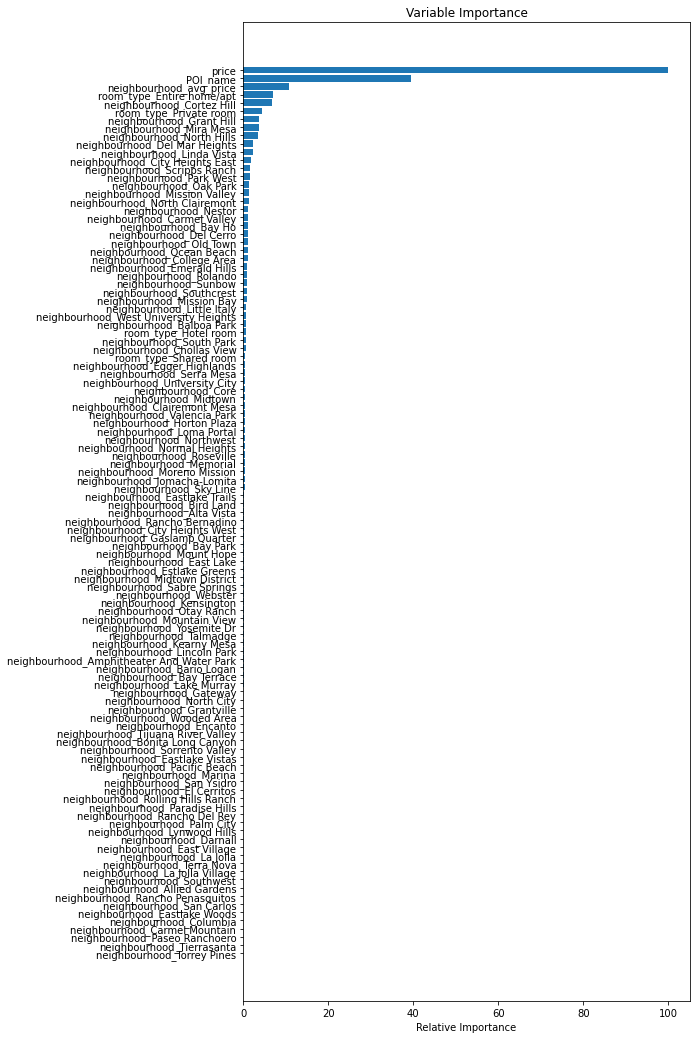

In [10]:

feature_importance = SD_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('VariableImportance.png')
plt.show()


In [11]:
features = list(set(HI_mod_gb_.columns) - set(['listing_id','Occupancy', 'NoVacancy', 'combo', 'rev_perunit_perDay',
                                 'Fall', 'Spring', 'Summer', 'Winter','Weekday','Weekend','Fall_weekday', 'Fall_weekend', 'Spring_weekday', 'Spring_weekend', 'Summer_weekday', 'Summer_weekend',
                            'Winter_weekday', 'Winter_weekend',]))

X = HI_mod_gb_[features]

y = HI_mod_gb_['NoVacancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)


HI_reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
HI_reg.score(X_test, y_test)

0.16111975011846125

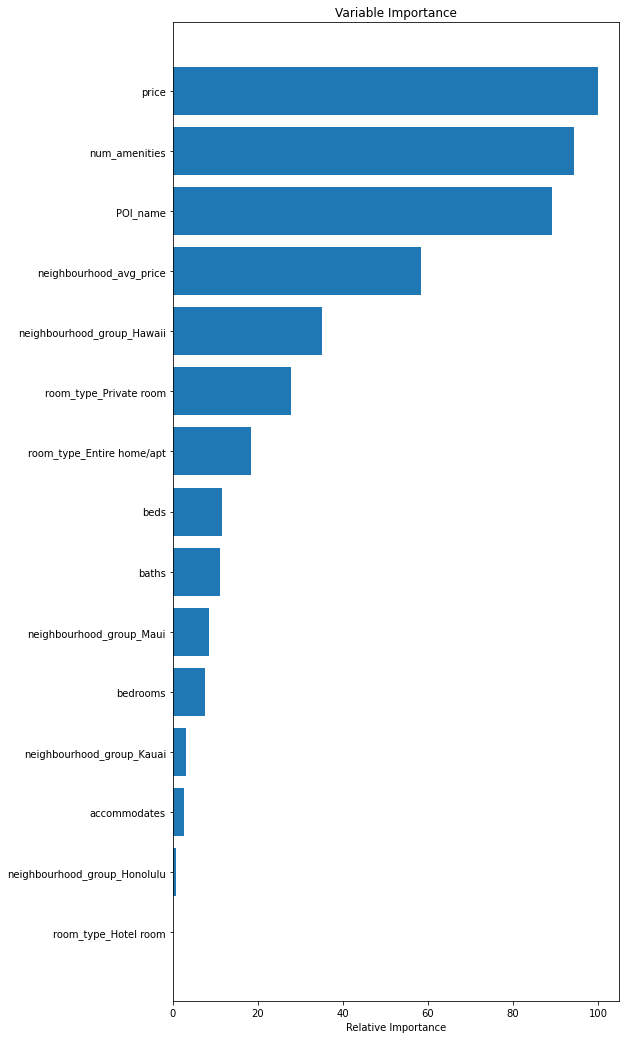

In [12]:
feature_importance = HI_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('VariableImportance.png')
plt.show()


In [63]:
from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        print("self.params ", self.params )
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring='r2', refit='r2',
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores)
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
#             print("self",self.__dict__)
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
#                 print("r",r)
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    

In [70]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import tree
import numpy as np

models1 = {
#     'LogisticRegression':LogisticRegression(),
#     'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
#     'AdaBoostRegressor': AdaBoostRegressor(),
#     'GradientBoostingRegressor': GradientBoostingRegressor()
}

params1 = {
#     'LogisticRegression': {'solver':['lbfgs','liblinear'],'random_state':[0]},
#     'ExtraTreesRegressor': { 'n_estimators': [(i+1)*150  for i in range(10)],'max_depth': [(i+1)*5 for i in range(6)] },
    'RandomForestRegressor': { 'n_estimators': [(i+1)*50 for i in range(3)],'max_depth': [(i+3)*2 for i in range(6)], 'random_state':[0],'min_samples_split':[5, 15, 30] },
#     'AdaBoostRegressor':  { 'n_estimators': [(i+1)*50  for i in range(3)], 'learning_rate': [ 0.1, 0.05, .01] },
#     'GradientBoostingRegressor': { 'n_estimators': [(i+1)*50  for i in range(3)],'min_samples_split':[35, 10, 25], 'max_depth': [(i)*3+7 for i in range(3)], 'learning_rate': [ 0.015, .05],  'random_state':[0] },
    }

In [71]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train, y_train, scoring='accuracy', n_jobs=-1)
helper.score_summary(sort_by='mean_score').head(5)

self.params  {'RandomForestRegressor': {'n_estimators': [50, 100, 150], 'max_depth': [6, 8, 10, 12, 14, 16], 'random_state': [0], 'min_samples_split': [5, 15, 30]}}
Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 54 candidates, totalling 162 fits
RandomForestRegressor


,estimator,min_score,mean_score,max_score,std_score,max_depth,min_samples_split,n_estimators,random_state
28,RandomForestRegressor,0.123258,0.127473,0.134933,0.005289,12,5,100,0
29,RandomForestRegressor,0.121399,0.126827,0.135758,0.006364,12,5,150,0
19,RandomForestRegressor,0.118561,0.126449,0.138478,0.008643,10,5,100,0
38,RandomForestRegressor,0.12212,0.126196,0.133871,0.00543,14,5,150,0
31,RandomForestRegressor,0.119937,0.126195,0.134516,0.006128,12,15,100,0


In [72]:
helper.score_summary(sort_by='mean_score')

RandomForestRegressor


,estimator,min_score,mean_score,max_score,std_score,max_depth,min_samples_split,n_estimators,random_state
28,RandomForestRegressor,0.123258,0.127473,0.134933,0.005289,12,5,100,0
29,RandomForestRegressor,0.121399,0.126827,0.135758,0.006364,12,5,150,0
19,RandomForestRegressor,0.118561,0.126449,0.138478,0.008643,10,5,100,0
38,RandomForestRegressor,0.12212,0.126196,0.133871,0.00543,14,5,150,0
31,RandomForestRegressor,0.119937,0.126195,0.134516,0.006128,12,15,100,0
37,RandomForestRegressor,0.122699,0.12613,0.13284,0.004745,14,5,100,0
41,RandomForestRegressor,0.119203,0.125736,0.132929,0.005623,14,15,150,0
40,RandomForestRegressor,0.121062,0.12566,0.13248,0.004919,14,15,100,0
50,RandomForestRegressor,0.121375,0.125641,0.131742,0.004427,16,15,150,0
49,RandomForestRegressor,0.1224,0.125418,0.131378,0.004215,16,15,100,0
